1. Viz1: /nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734
2. #path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734/checkpoints/' 5% mse error for the saved_model_max_recall
3. path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220226_0040/checkpoints' 3% mse for saved_model
 


In [90]:
path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220226_0040/checkpoints'
saved_model_path = path +'/saved_model.pt'
saved_model_max_recall_path = path + '/saved_model_max_recall.pt'

In [87]:
take = saved_model_path

In [88]:

import torch
saved_model = torch.load(take)

In [89]:
import math
import torch
import numpy as np
#from config import *
from misc.utils import *
import torch.nn.functional as F

class PerformancePredictor(torch.nn.Module):
    def __init__(self):
        super(PerformancePredictor, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(self.n_dims*2, 1)

    def forward(self, q, m):
        p = torch.cat([q, m], 1)
        p = torch.sigmoid(self.fc(p))
        return p

class ModelEncoder(torch.nn.Module):
    def __init__(self):
        super(ModelEncoder, self).__init__()  
        self.n_dims = 128
        self.fc = torch.nn.Linear(2048, self.n_dims) #torch.nn.Linear(45+1536, self.args.n_dims) 
            
    def forward(self, v_f):
        m = v_f
        m = F.normalize(m)
        m = self.fc(m)
        m = self.l2norm(m)
        return m

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x
    
class QueryEncoder(torch.nn.Module):
    def __init__(self):
        super(QueryEncoder, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(512, self.n_dims) 

    def forward(self, D):
        q = []
        for d in D:
            _q = self.fc(d) 
            _q = torch.mean(_q, 0)
            _q = self.l2norm(_q.unsqueeze(0))
            q.append(_q)
        q = torch.stack(q).squeeze()
        return q

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x

In [5]:

device = 'cpu'
enc_q = QueryEncoder().to(device) 
enc_q.load_state_dict(saved_model['enc_q'])
enc_m = ModelEncoder().to(device)
enc_m.load_state_dict(saved_model['enc_m'])
pred = PerformancePredictor().to(device)
pred.load_state_dict(saved_model['predictor'])

epoch = saved_model['epoch']
recall = saved_model['recall']
medr = saved_model['medr']
meanr = saved_model['meanr']
mse = saved_model['mse']

In [6]:
model_zoo_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_mod_zoo.pt'
data_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_data_path'
import os
model_zoo = torch.load(model_zoo_path)
query = torch.load(os.path.join(data_path, 'meta_train.pt'))

In [7]:
query.keys()

dict_keys(['Brain_MRI', 'RSNAXRay', 'kits', 'IHD_Brain', 'MosMed', 'ImageCHD', 'Covid19XRay', 'RSPECT', 'CTPancreas', 'LiTs', 'ProstateMRI'])

torch.stack(query['zalando-store-crawl_dqmonn_0_6']['x_query_train']).shape

In [8]:
import pandas as pd
f_model_zoo = pd.DataFrame(model_zoo)

In [9]:
f_model_zoo

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,46,0.826667,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,11,0.776667,0.263736,0.507455,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,False,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,16,0.708333,0.235808,0.549068,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,False,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,95,0.950000,0.210526,0.150664,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet50,True,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,22,0.818750,0.188811,0.089775,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,mobilenet_v2,True,False,False,False,raw,"[tensor(2.0657), tensor(2.1143), tensor(1.8511..."
376,100,0.932258,0.932258,0.013777,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,resnet18,True,True,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.4187), tenso..."
377,44,0.759375,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
378,85,0.859747,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


def process_topol(topol):
    ks = topol[:20] 
    e = topol[20:40]
    d = topol[40:]
    tmp = torch.zeros(len(ks))
    for stage, num_layer in enumerate(d):
        tmp[stage*4:stage*4+num_layer] = 1
    ks = torch.tensor(ks) * tmp
    e = torch.tensor(e) * tmp
    topol = [int(t) for t in [*ks.tolist(), *e.tolist(), *d]]
    return topol

In [10]:
set(model_zoo['dataset'])

{'Brain_MRI',
 'CTPancreas',
 'Covid19XRay',
 'IHD_Brain',
 'ImageCHD',
 'LiTs',
 'MosMed',
 'ProstateMRI',
 'RSNAXRay',
 'RSPECT',
 'kits'}

In [11]:
pd.DataFrame(model_zoo)

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,46,0.826667,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,11,0.776667,0.263736,0.507455,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,False,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,16,0.708333,0.235808,0.549068,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,False,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,95,0.950000,0.210526,0.150664,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet50,True,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,22,0.818750,0.188811,0.089775,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,mobilenet_v2,True,False,False,False,raw,"[tensor(2.0657), tensor(2.1143), tensor(1.8511..."
376,100,0.932258,0.932258,0.013777,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,resnet18,True,True,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.4187), tenso..."
377,44,0.759375,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
378,85,0.859747,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [311]:
z = pd.DataFrame(model_zoo)
set(z[z['f1']>0.55]['dataset'])

{'Brain_MRI',
 'CTPancreas',
 'Covid19XRay',
 'IHD_Brain',
 'ImageCHD',
 'LiTs',
 'MosMed',
 'ProstateMRI',
 'RSNAXRay',
 'RSPECT',
 'kits'}

Collate Dataset and Model Embeddings.
1. Iterate on all datasets
    1. First embed dataset
    2. Then pick models trained on those datasets. Embed those models.


In [12]:
# Get Trained embeddings
import torch
data_emb_list = list()
n_datasets = 100
i = 1
for dataset in list(set(model_zoo['dataset']) - set(['RSNAXRay'])):            
    enc = enc_q([torch.stack(query[dataset]['x_query_train'])])
    d_emb = {'name': f'D_{dataset}', 'emb': enc.detach().cpu().numpy(), 'dataset': dataset,  'color':i}
    data_emb_list.append(d_emb)

    dataset_models = f_model_zoo[f_model_zoo['dataset'] == dataset]
    
    
    # iterate over dataframe

    for index, row in dataset_models.iterrows():
        #model_name = row['model_name']
        #topol = torch.tensor(process_topol(row['topol']))
        enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))
        m_emb = {'name': 'M_%.2f'%(row["acc"]), \
            'emb': enc.squeeze().detach().cpu().numpy(), \
            'color':i\
            }
        row_dict = row.to_dict()
        for key, value in row_dict.items():
           m_emb[key] = value 
            
        data_emb_list.append(m_emb)
        
    i += 1

/tmp/ipykernel_7062/1651087357.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))


### Performance Predictor's prediction of (model, dataset) performance

In [11]:
set(f_model_zoo[(f_model_zoo['balanced'] == True)]['dataset'])

{'Brain_MRI', 'CTPancreas', 'IHD_Brain', 'LiTs', 'MosMed', 'RSPECT', 'kits'}

In [12]:
f_model_zoo[(f_model_zoo['balanced'] == True) & ((f_model_zoo['topn'] == 'top-2')|(f_model_zoo['topn'] == 'raw'))]

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5,81,0.793333,0.798046,0.478533,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,mobilenet_v2,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
6,18,0.813333,0.827692,0.451216,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
7,72,0.788333,0.803709,0.396533,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,densenet121,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
15,66,0.790000,0.795455,0.464588,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,densenet121,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
17,88,0.813333,0.816393,0.397128,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,efficientnet_b4,True,True,False,True,top-2,"[tensor(0.0059), tensor(0.0282), tensor(-0.004..."
20,51,0.798333,0.787346,0.431066,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
21,37,0.753333,0.773006,0.462227,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
24,75,0.796667,0.811146,0.411682,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,densenet121,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
25,13,0.800000,0.821429,0.489994,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [21]:

dataset_list = list(set(model_zoo['dataset']))
predicted_data_model = list()
for dataset in dataset_list:
    for index, row in pd.DataFrame(model_zoo).iterrows():

        # All (Dataset ,Model) pairs. Using model_path as unique identifier of model
        q_encoding = [torch.stack(query[dataset]['x_query_train'])]
        m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)
        q_emb = enc_q(q_encoding).detach().unsqueeze(0).cpu().numpy()
        m_emb = enc_m(m_encoding).detach().cpu().numpy()
        #print(q_emb.shape, m_emb.shape)
        pred_emb = pred(torch.from_numpy(q_emb).to(device), torch.from_numpy(m_emb).to(device))
        pred_emb = pred_emb.detach().cpu().numpy()
        pred_emb = pred_emb.squeeze()
        
        store = {'target_dataset': dataset, 'pred_f1': pred_emb}
        for key, value in row.to_dict().items():
            store[key] = value
        predicted_data_model.append(store)
        

/tmp/ipykernel_7062/3781752281.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)


In [31]:
d_m = pd.DataFrame(predicted_data_model)
d_m[['target_dataset', 'pred_f1', 'model', 'f1', 'dataset', 'model_path']]

,target_dataset,pred_f1,model,f1,dataset,model_path
0,Covid19XRay,0.31401205,resnet18,0.452632,IHD_Brain,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1,Covid19XRay,0.71311593,resnet50,0.790698,IHD_Brain,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2,Covid19XRay,0.33024684,resnet18,0.263736,RSPECT,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3,Covid19XRay,0.36591202,mobilenet_v2,0.235808,RSPECT,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4,Covid19XRay,0.31404465,resnet50,0.210526,RSPECT,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
...,...,...,...,...,...,...
4175,LiTs,0.2421294,mobilenet_v2,0.188811,ImageCHD,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4176,LiTs,0.5237659,resnet18,0.932258,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4177,LiTs,0.73111796,resnet18,0.702703,MosMed,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4178,LiTs,0.44404027,resnet50,0.530511,kits,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [33]:
d_m[['target_dataset', 'pred_f1', 'model', 'f1', 'dataset', 'model_path']].sort_values(by=['pred_f1'], ascending=False)

,target_dataset,pred_f1,model,f1,dataset,model_path
1312,ProstateMRI,0.97089744,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1373,ProstateMRI,0.9677741,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1334,ProstateMRI,0.9676828,resnet50,0.948333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2832,RSNAXRay,0.96656525,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
932,Brain_MRI,0.9638656,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
...,...,...,...,...,...,...
3059,RSPECT,0.071289085,resnet50,0.097643,RSPECT,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3371,RSPECT,0.06547251,mobilenet_v2,0.106250,ImageCHD,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3334,RSPECT,0.059123617,efficientnet_b4,0.073585,ImageCHD,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3408,RSPECT,0.0501445,resnet50,0.094118,ImageCHD,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [44]:
f_model_zoo.sort_values(by=['f1'], ascending=False)

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
172,75,0.960000,0.960000,0.001566,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,resnet18,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
271,70,0.957861,0.957861,0.030250,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,mobilenet_v2,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
264,88,0.956240,0.956240,0.004379,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.0860), tensor(0.), tenso..."
195,84,0.951667,0.951667,0.085034,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,efficientnet_b4,True,False,False,False,top-7,"[tensor(0.0280), tensor(0.0074), tensor(-0.119..."
194,100,0.948333,0.948333,0.023204,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,resnet50,True,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,10,0.777344,0.083601,0.196370,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,resnet50,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
294,4,0.232813,0.073585,5.412927,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,efficientnet_b4,True,False,True,True,raw,"[tensor(82632.0156), tensor(0.), tensor(0.), t..."
155,1,0.950000,0.000000,2.201054,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,efficientnet_b4,True,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(23..."
126,1,0.950000,0.000000,0.504810,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,False,False,False,top-7,"[tensor(0.2332), tensor(0.0025), tensor(0.2142..."


In [43]:
d_m[['target_dataset', 'pred_f1', 'model', 'f1', 'dataset', 'model_path']].sort_values(by=['pred_f1'], ascending=False).groupby('target_dataset').head(2)

,target_dataset,pred_f1,model,f1,dataset,model_path
1312,ProstateMRI,0.97089744,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1373,ProstateMRI,0.9677741,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2832,RSNAXRay,0.96656525,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
932,Brain_MRI,0.9638656,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2893,RSNAXRay,0.96299475,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2072,IHD_Brain,0.96170074,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2452,CTPancreas,0.9609731,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
993,Brain_MRI,0.9600187,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2133,IHD_Brain,0.9576336,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2513,CTPancreas,0.95683205,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [40]:
d_m[['target_dataset', 'pred_f1', 'model', 'f1', 'dataset', 'model_path']].sort_values(by=['pred_f1'], ascending=False).groupby('target_dataset').head(3)

,target_dataset,pred_f1,model,f1,dataset,model_path
1312,ProstateMRI,0.97089744,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1373,ProstateMRI,0.9677741,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1334,ProstateMRI,0.9676828,resnet50,0.948333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2832,RSNAXRay,0.96656525,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
932,Brain_MRI,0.9638656,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2893,RSNAXRay,0.96299475,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2854,RSNAXRay,0.96289045,resnet50,0.948333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2072,IHD_Brain,0.96170074,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2452,CTPancreas,0.9609731,resnet18,0.960000,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
993,Brain_MRI,0.9600187,resnet50,0.933333,Brain_MRI,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [45]:
f_model_zoo

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,46,0.826667,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,11,0.776667,0.263736,0.507455,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,False,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,16,0.708333,0.235808,0.549068,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,False,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,95,0.950000,0.210526,0.150664,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet50,True,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,22,0.818750,0.188811,0.089775,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,mobilenet_v2,True,False,False,False,raw,"[tensor(2.0657), tensor(2.1143), tensor(1.8511..."
376,100,0.932258,0.932258,0.013777,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,resnet18,True,True,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.4187), tenso..."
377,44,0.759375,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
378,85,0.859747,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [24]:
# Show all rows
temp = d_m [d_m['target_dataset'] == d_m['dataset']][['target_dataset', 'pred_f1', 'model', 'f1', 'dataset']]

In [25]:

# calculate MSE between temp['f1'], temp['pred_f1'] 
f1 = temp['f1'].to_numpy()
pred_f1 = temp['pred_f1'].to_numpy()

In [26]:
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
mse = np.mean((f1 - pred_f1)**2)

abs_dif = np.abs(pred_f1 - f1)
# calculate mean, standard deviation of abs_dif
mean = np.mean(abs_dif)
std = np.std(abs_dif)


In [27]:
mean, std

(0.0553091770031884, 0.08502042146411076)

mean, std : (0.16189234127213195, 0.16484129624616373)

mse:0.053381783110687954

## Visualizations below

In [76]:
# Do T-sne visualization of the embeddings in data_emb_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE, LocallyLinearEmbedding, LocallyLinearEmbedding, SpectralEmbedding, MDS, Isomap
from sklearn.decomposition import PCA

# Visualize embeddings
def visualize_embeddings(data_emb_list, title, method, return_emb=True):
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'indigo', 'lime', 'olive', 'teal', 'navy', 'maroon', 'black', 'gold', 'silver', 'gray', 'crimson', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'darkgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray']

    # Visualize embeddings
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        results = tsne.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'pca':
        pca = PCA(n_components=2)
        results = pca.fit_transform([d['emb'] for d in data_emb_list])
        # print explained variance
        print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
        
    elif method =='isomap':
        isomap = Isomap(n_components=2)
        results = isomap.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'lle': 
        lle = LocallyLinearEmbedding(n_components=2)
        results = lle.fit_transform([d['emb'] for d in data_emb_list])

    if return_emb:
        return results
        
    plt.figure(figsize=(40, 40))
    
    for i, d in enumerate(data_emb_list):
        x, y = results[i, :]
        plt.scatter(x, y, c=colors[d['color']-1], s=50)
        plt.annotate(d['name'], (x, y), fontsize=18 if 'D' in d['name'] else 9, color=colors[d['color']-1] if 'D' in d['name'] else 'black')
    plt.title(title)
    plt.show()


In [77]:
d = dict()
d['pca'] = visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=True)
d['tsne'] = visualize_embeddings(data_emb_list, 't-SNE', 'tsne', return_emb=True)
d['isomap'] = visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=True)
d['lle'] = visualize_embeddings(data_emb_list, 'Locally Linear Embedding', 'lle', return_emb=True)

explained variance ratio (first two components): [0.24477553 0.21343901]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.000s...
[t-SNE] Computed neighbors for 380 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 0.342330


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.431854
[t-SNE] KL divergence after 300 iterations: 0.266058


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [51]:
import pandas as pd
true = pd.DataFrame(data_emb_list)
true_emb = np.array(pd.DataFrame(true['emb']).values.tolist()).squeeze(1)

In [52]:
true_emb.shape

(380, 128)

In [71]:
# Compute the distance matrix
from scipy.spatial.distance import pdist, squareform

def compute_distances(emb):
    return squareform(pdist(emb, 'euclidean'))
    # Calculate euclidian error between two distance matrices
def euclidian_error(true_distances, distances):
    return np.sqrt(np.sum(np.square(true_distances - distances)))
# Compute the distance matrix for true_emb
true_distances = compute_distances(true_emb)
viz_d = dict()
for key, value in d.items():
    viz_d[key] = compute_distances(value)
# iterate over all d methods and print euclidian error
for key, value in viz_d.items():
    print('Euclidian error for %s: %.2f'%(key, euclidian_error(true_distances, value)))

Euclidian error for pca: 209.09
Euclidian error for tsne: 5242.20
Euclidian error for isomap: 903.63
Euclidian error for lle: 459.41


In [98]:
results = {'model_zoo': f_model_zoo, 'd_pca': d['pca'], 'd_tsne': d['tsne'], 'd_isomap': d['isomap'], 'd_lle': d['lle'], 'true_distances': true_distances, 'labels_for_distances' : true['dataset'].unique()}

In [ ]:
torch.save(results, 'results.pth')

In [92]:
true['dataset'].unique()

array(['Covid19XRay', 'MosMed', 'Brain_MRI', 'ProstateMRI', 'kits',
       'IHD_Brain', 'CTPancreas', 'RSPECT', 'ImageCHD', 'LiTs'],
      dtype=object)

In [54]:
true_distances

array([[0.        , 1.6279806 , 1.40036581, ..., 1.74350768, 1.64808378,
        1.67116302],
       [1.6279806 , 0.        , 0.90277211, ..., 1.09269364, 1.13555228,
        1.19534485],
       [1.40036581, 0.90277211, 0.        , ..., 1.40035866, 1.44107829,
        1.48562438],
       ...,
       [1.74350768, 1.09269364, 1.40035866, ..., 0.        , 0.3999761 ,
        0.34927062],
       [1.64808378, 1.13555228, 1.44107829, ..., 0.3999761 , 0.        ,
        0.35300689],
       [1.67116302, 1.19534485, 1.48562438, ..., 0.34927062, 0.35300689,
        0.        ]])

In [83]:
# Visualize PCA with 3 components in 3d space
from mpl_toolkits.mplot3d import Axes3D

def visualize_pca_3d(data_emb_list, title, method):
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'indigo', 'lime', 'olive', 'teal', 'navy', 'maroon', 'black', 'gold', 'silver', 'gray', 'crimson', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'darkgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray']

    # Visualize embeddings
    if method == 'pca':
        pca = PCA(n_components=3)
        results = pca.fit_transform([d['emb'] for d in data_emb_list])
        # print explained variance
        print('explained variance ratio (first three components): %s' % str(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(40, 40))

    for i, d in enumerate(data_emb_list):
        x, y, z = results[i, :]
        plt.scatter(x, y, z, c=colors[d['color']-1])
        plt.annotate(d['name'], (x, y, z), fontsize=18 if 'D' in d['name'] else 9, color=colors[d['color']-1] if 'D' in d['name'] else 'black')
    plt.title(title)
    plt.show()


explained variance ratio (first three components): [0.24477553 0.21343901 0.14407323]


ValueError: too many values to unpack (expected 2)

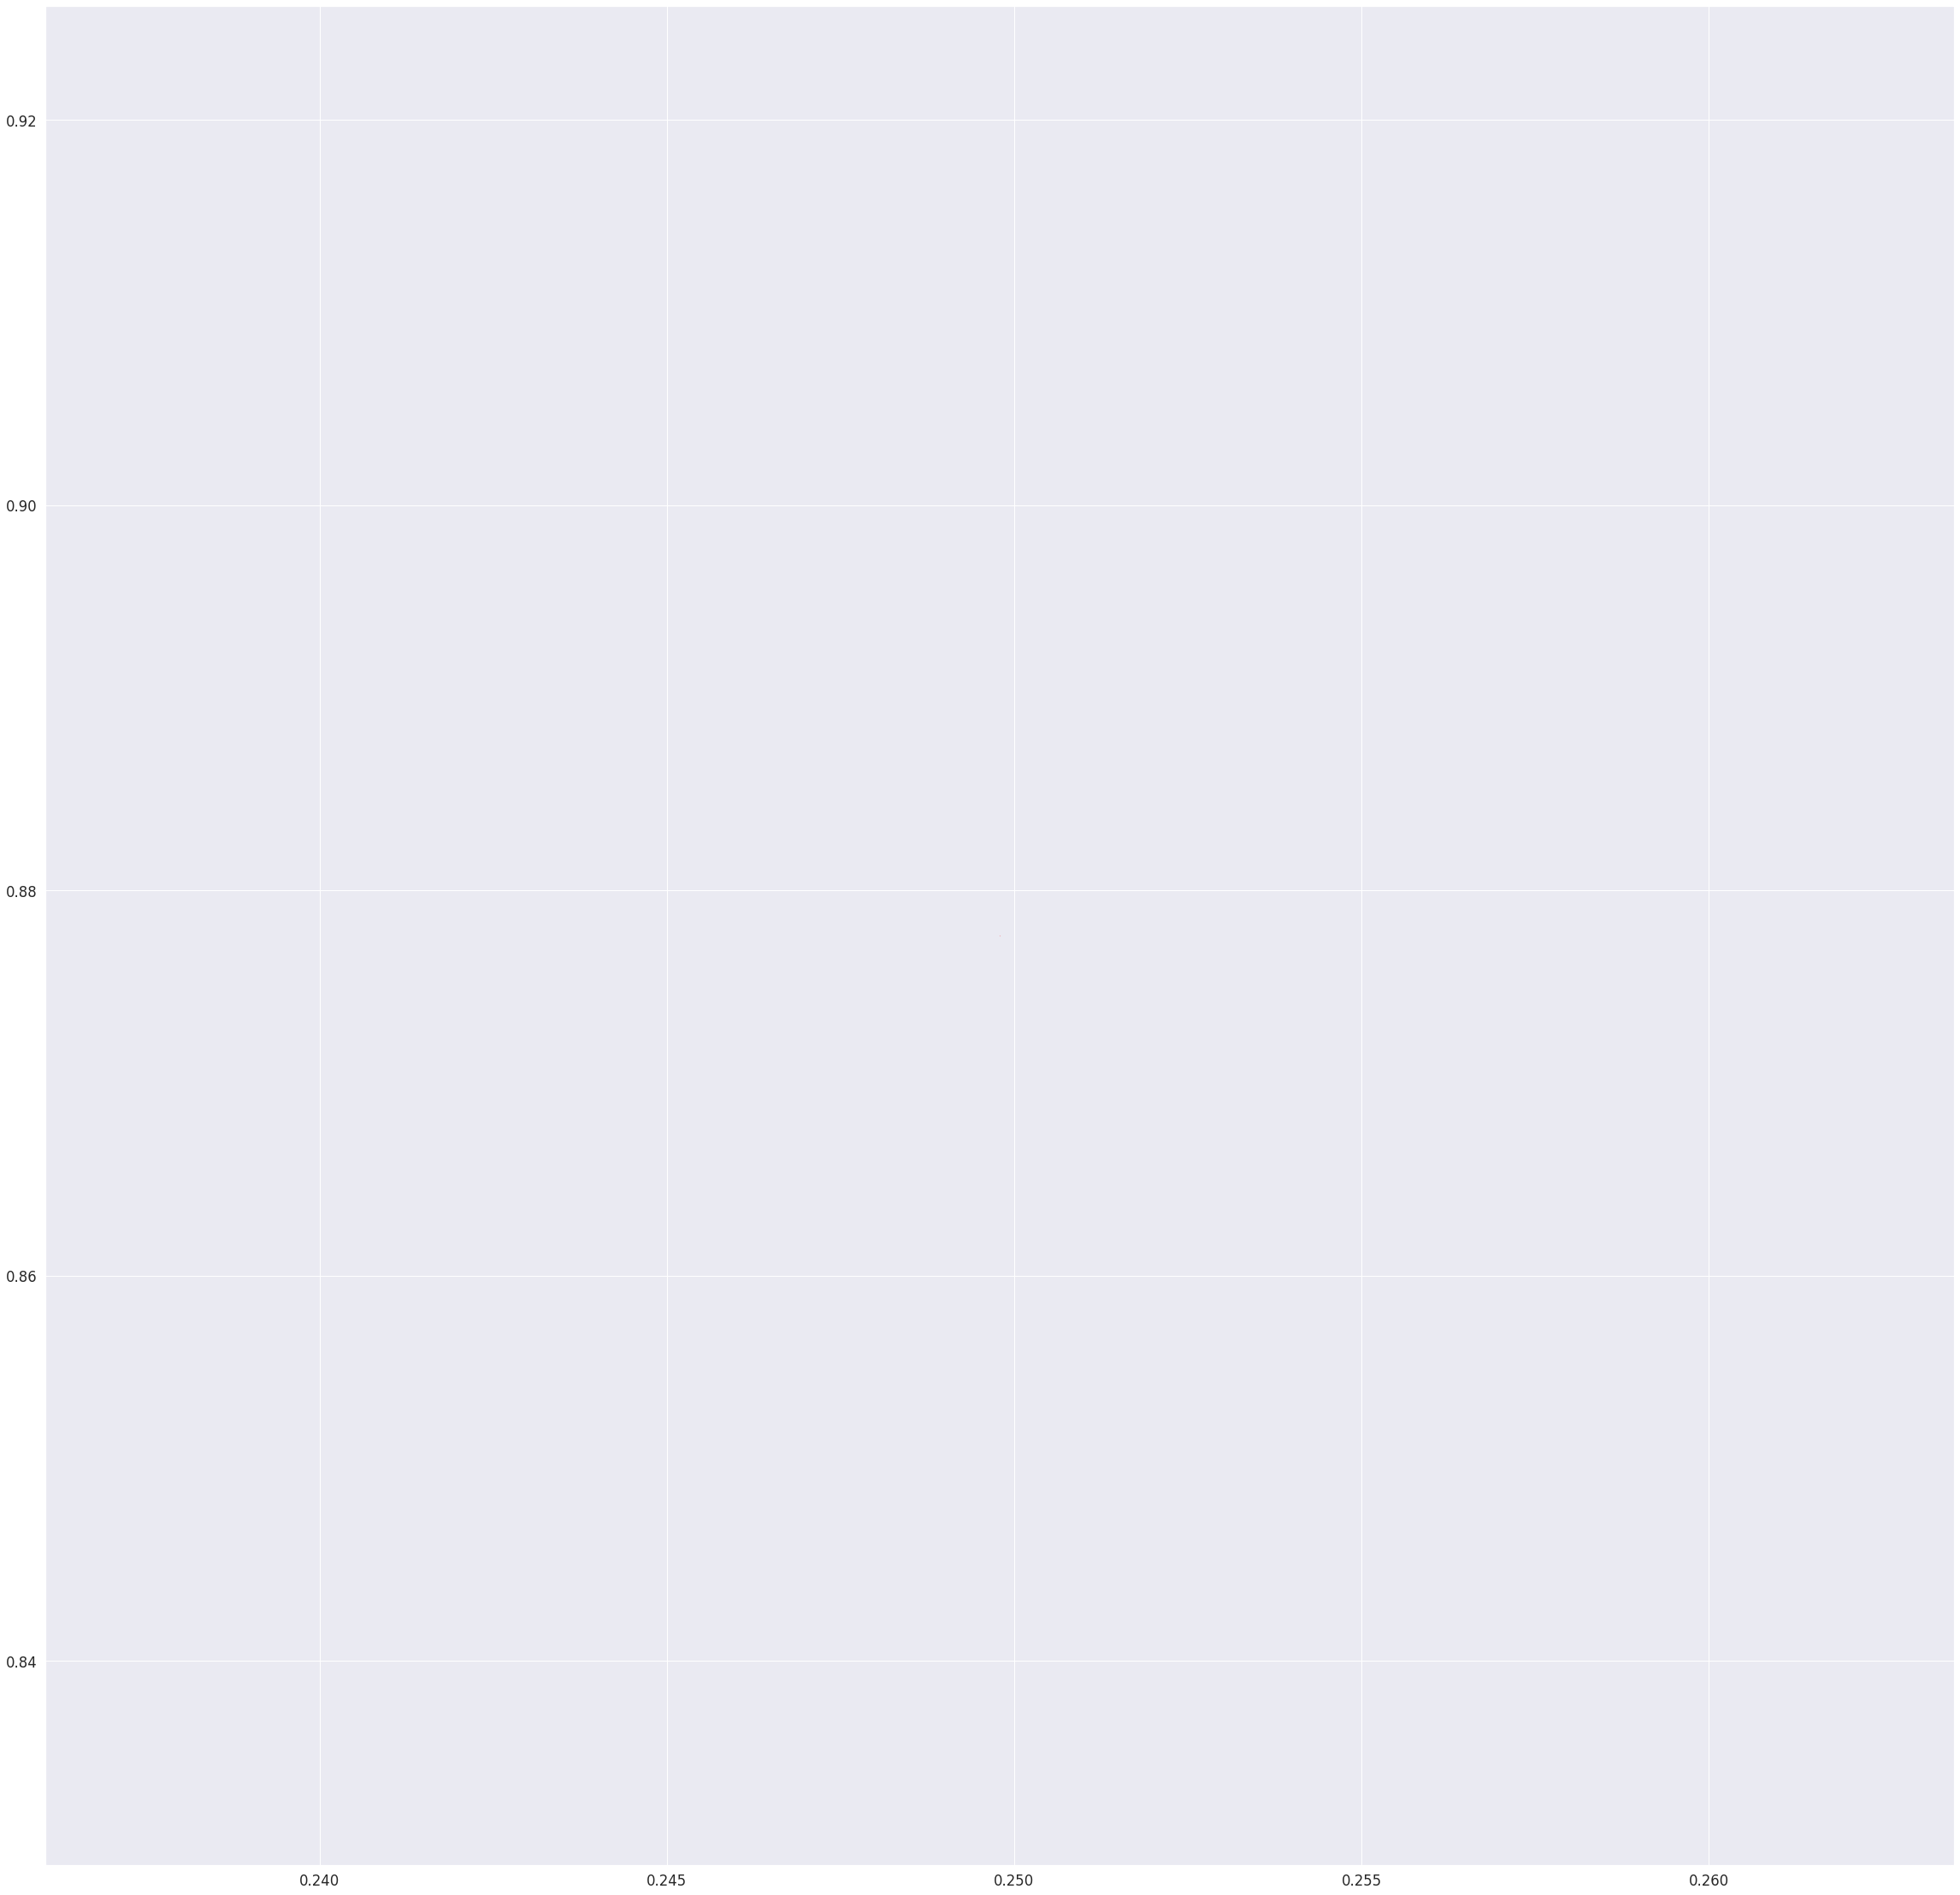

In [84]:
visualize_pca_3d(data_emb_list, 'PCA', 'pca')

In [67]:
# plot distance matrix true_distances with labels true['dataset']
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distance_matrix(distances, labels):
    # Add ticks every 10 samples and label them with the dataset name
    sns.set(font_scale=1.5)
    plt.figure(figsize=(40, 40))
    # add ticks for every 10th sample
    plt.xticks(np.arange(0, len(labels), 10), labels[::10], rotation=90)
    plt.yticks(np.arange(0, len(labels), 10), labels[::10])
    # plot the distance matrix
    ax = sns.heatmap(distances, square=True, annot=True, fmt='.2f', cmap='coolwarm')
    #plt.show()
    #ax = sns.heatmap(distances, xticklabels=labels, yticklabels=labels, cmap='viridis')
    ax.set_title('Distance matrix')
    plt.show()

In [68]:
pca_distances = compute_distances(d['pca'])
plot_distance_matrix(pca_distances, true['dataset'])

KeyboardInterrupt: 

In [63]:
true['dataset'].unique()

array(['Covid19XRay', 'MosMed', 'Brain_MRI', 'ProstateMRI', 'kits',
       'IHD_Brain', 'CTPancreas', 'RSPECT', 'ImageCHD', 'LiTs'],
      dtype=object)

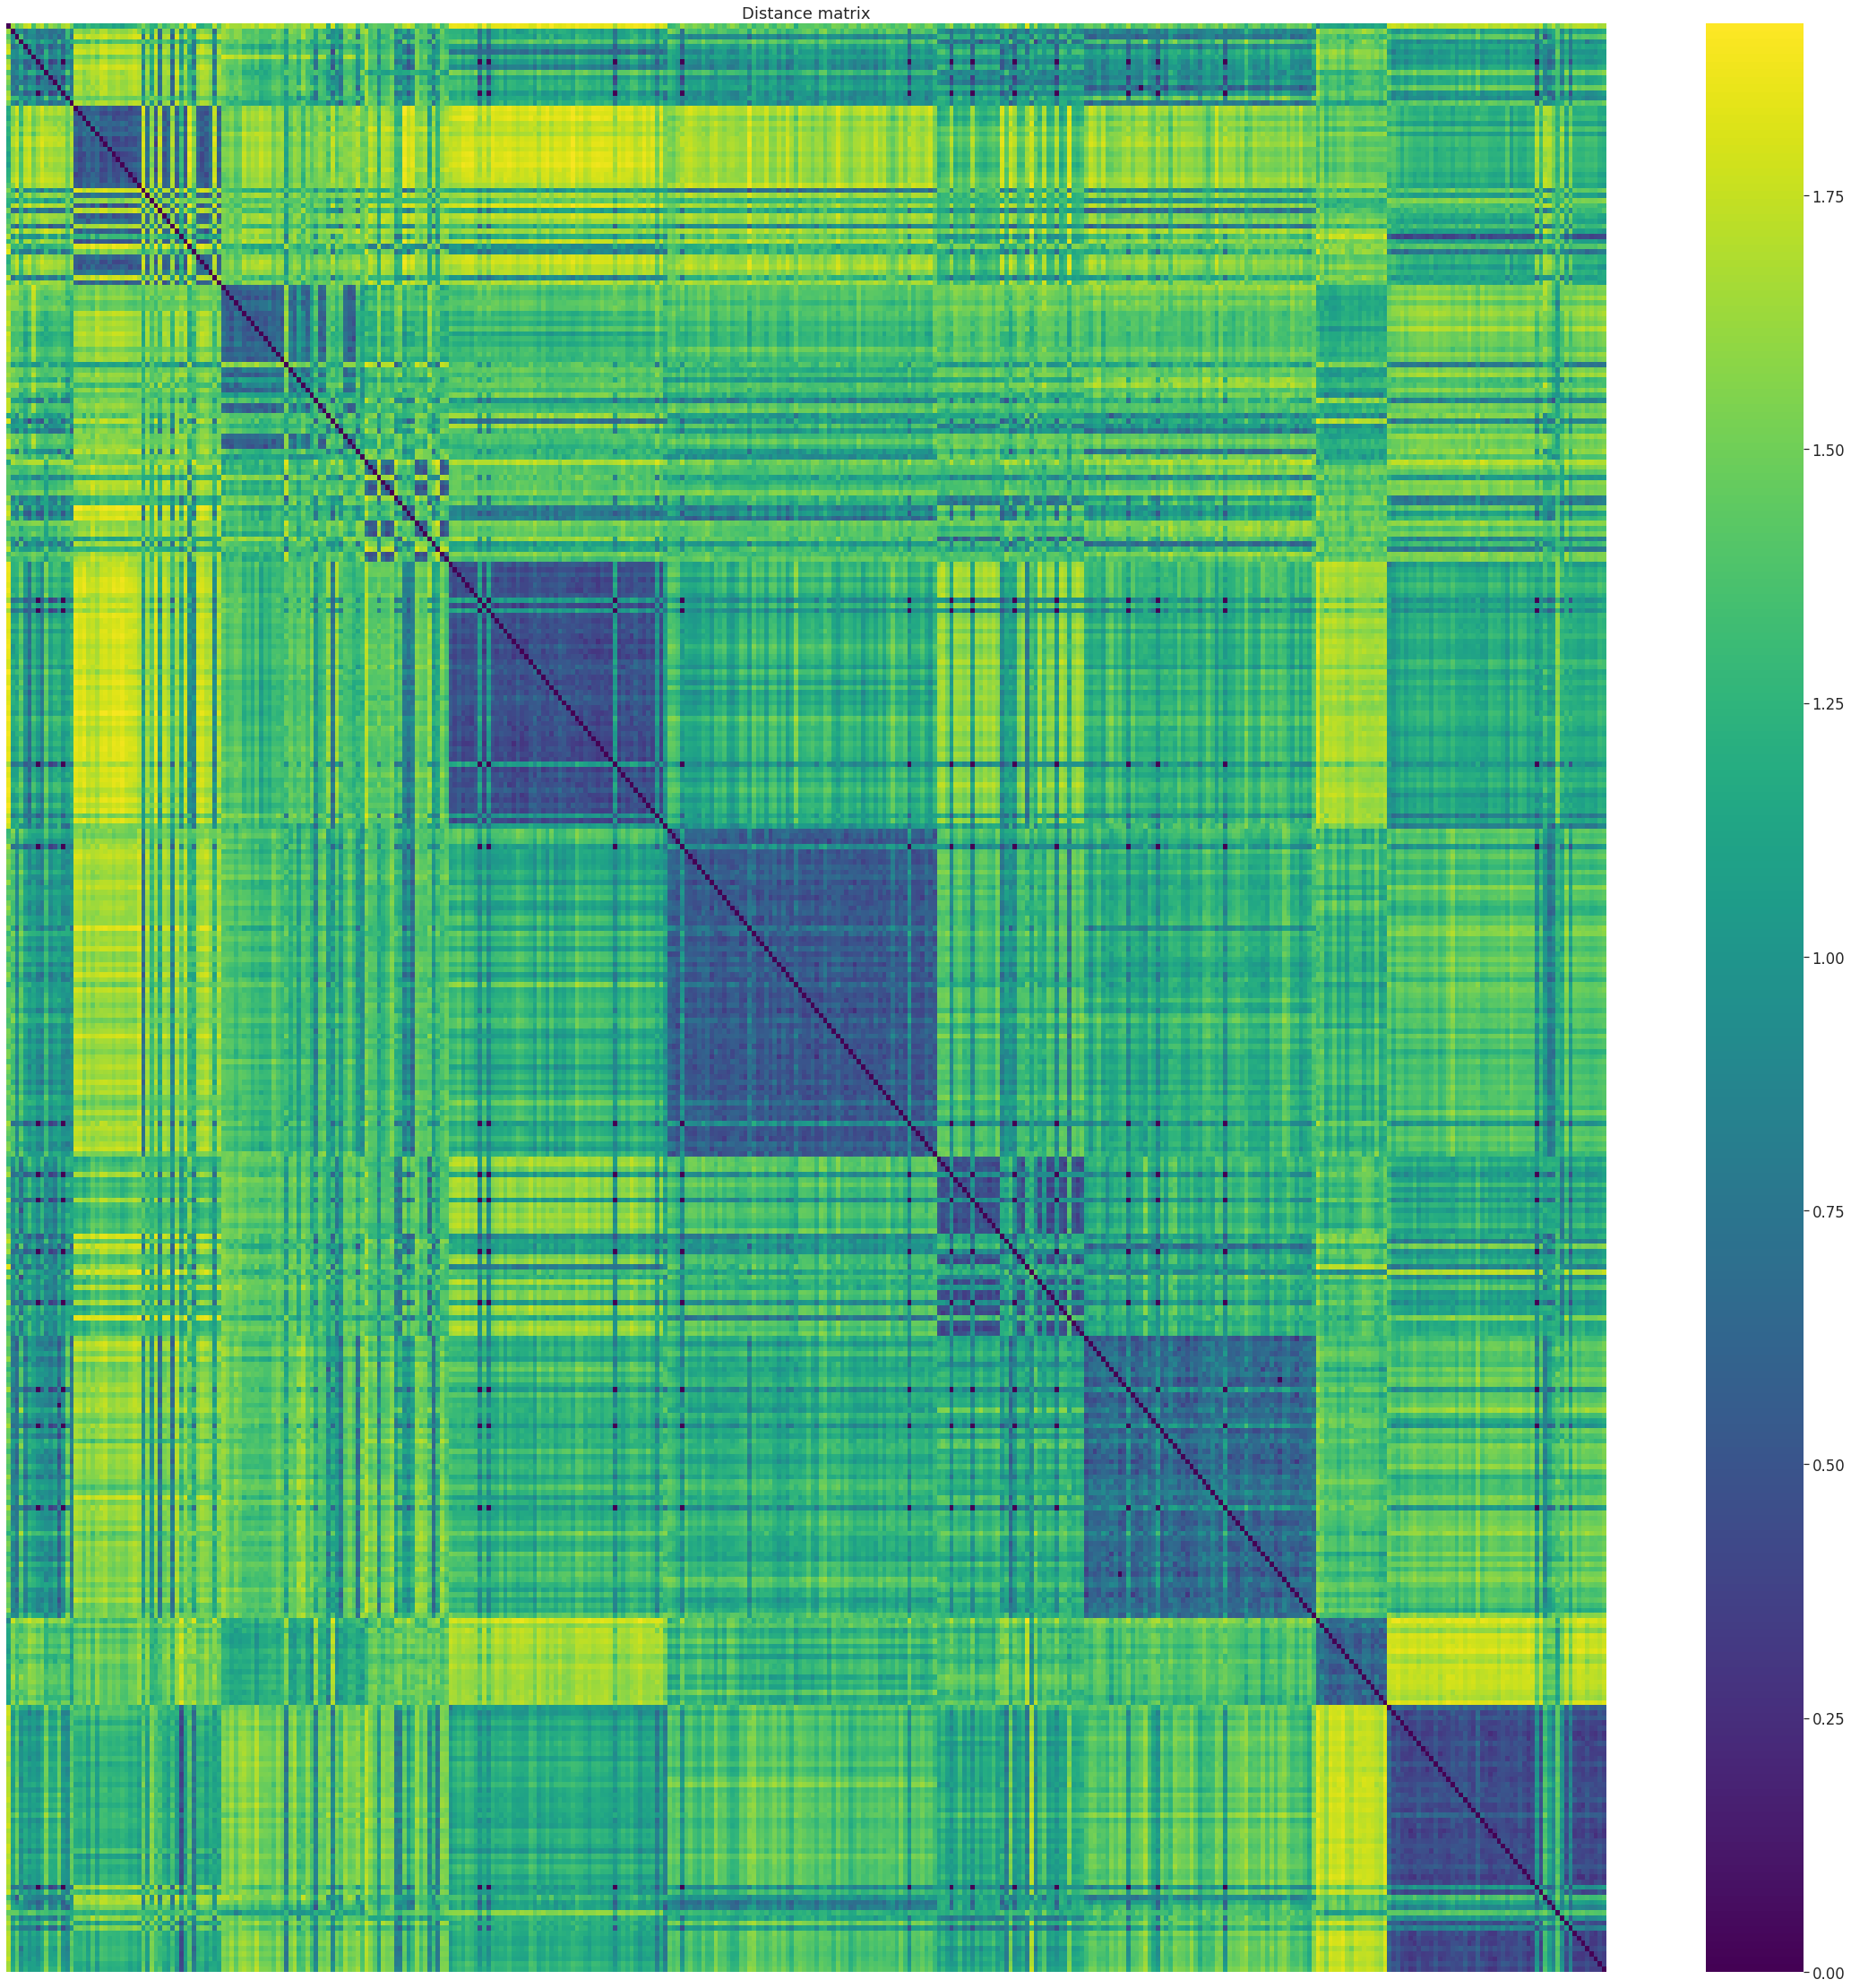

In [59]:
plot_distance_matrix(true_distances, [])

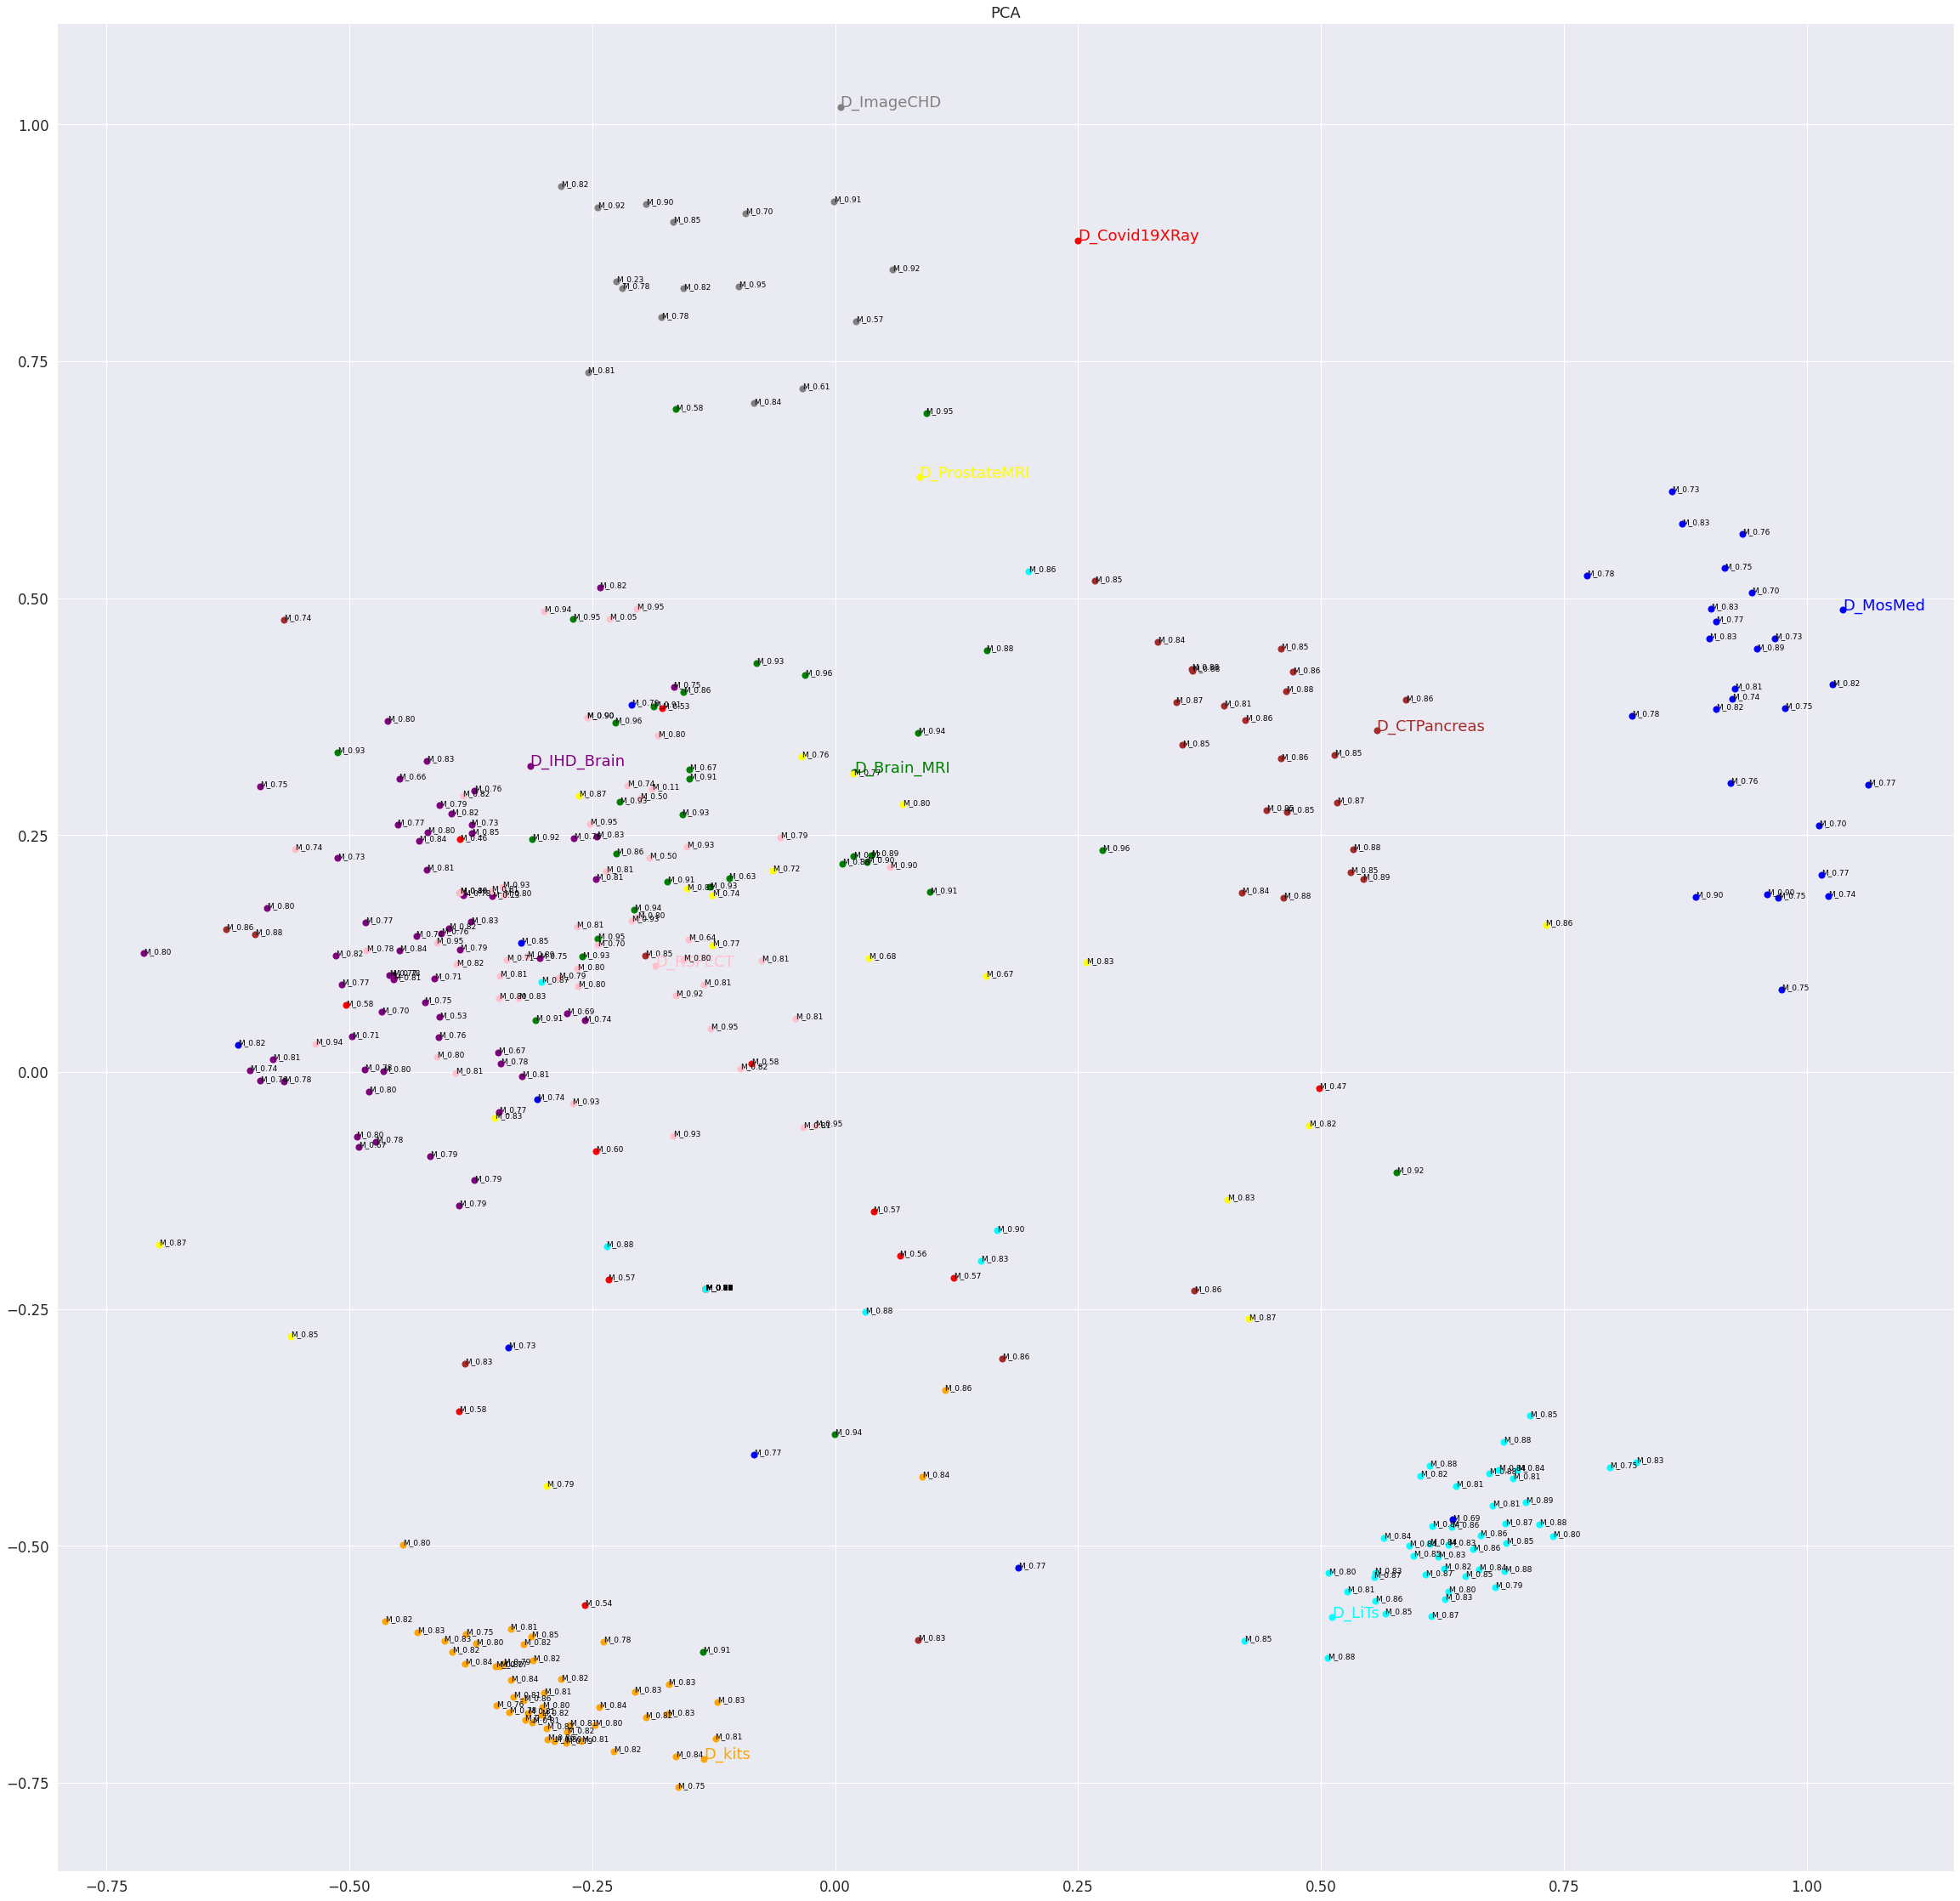

In [75]:
# PCA Visualization
visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=False)

# LLE Visualization
visualize_embeddings(data_emb_list, 'LLE', 'lle', return_emb=False)


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 327 samples in 0.001s...
[t-SNE] Computed neighbors for 327 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 0.368569
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.046753
[t-SNE] KL divergence after 300 iterations: 0.155269


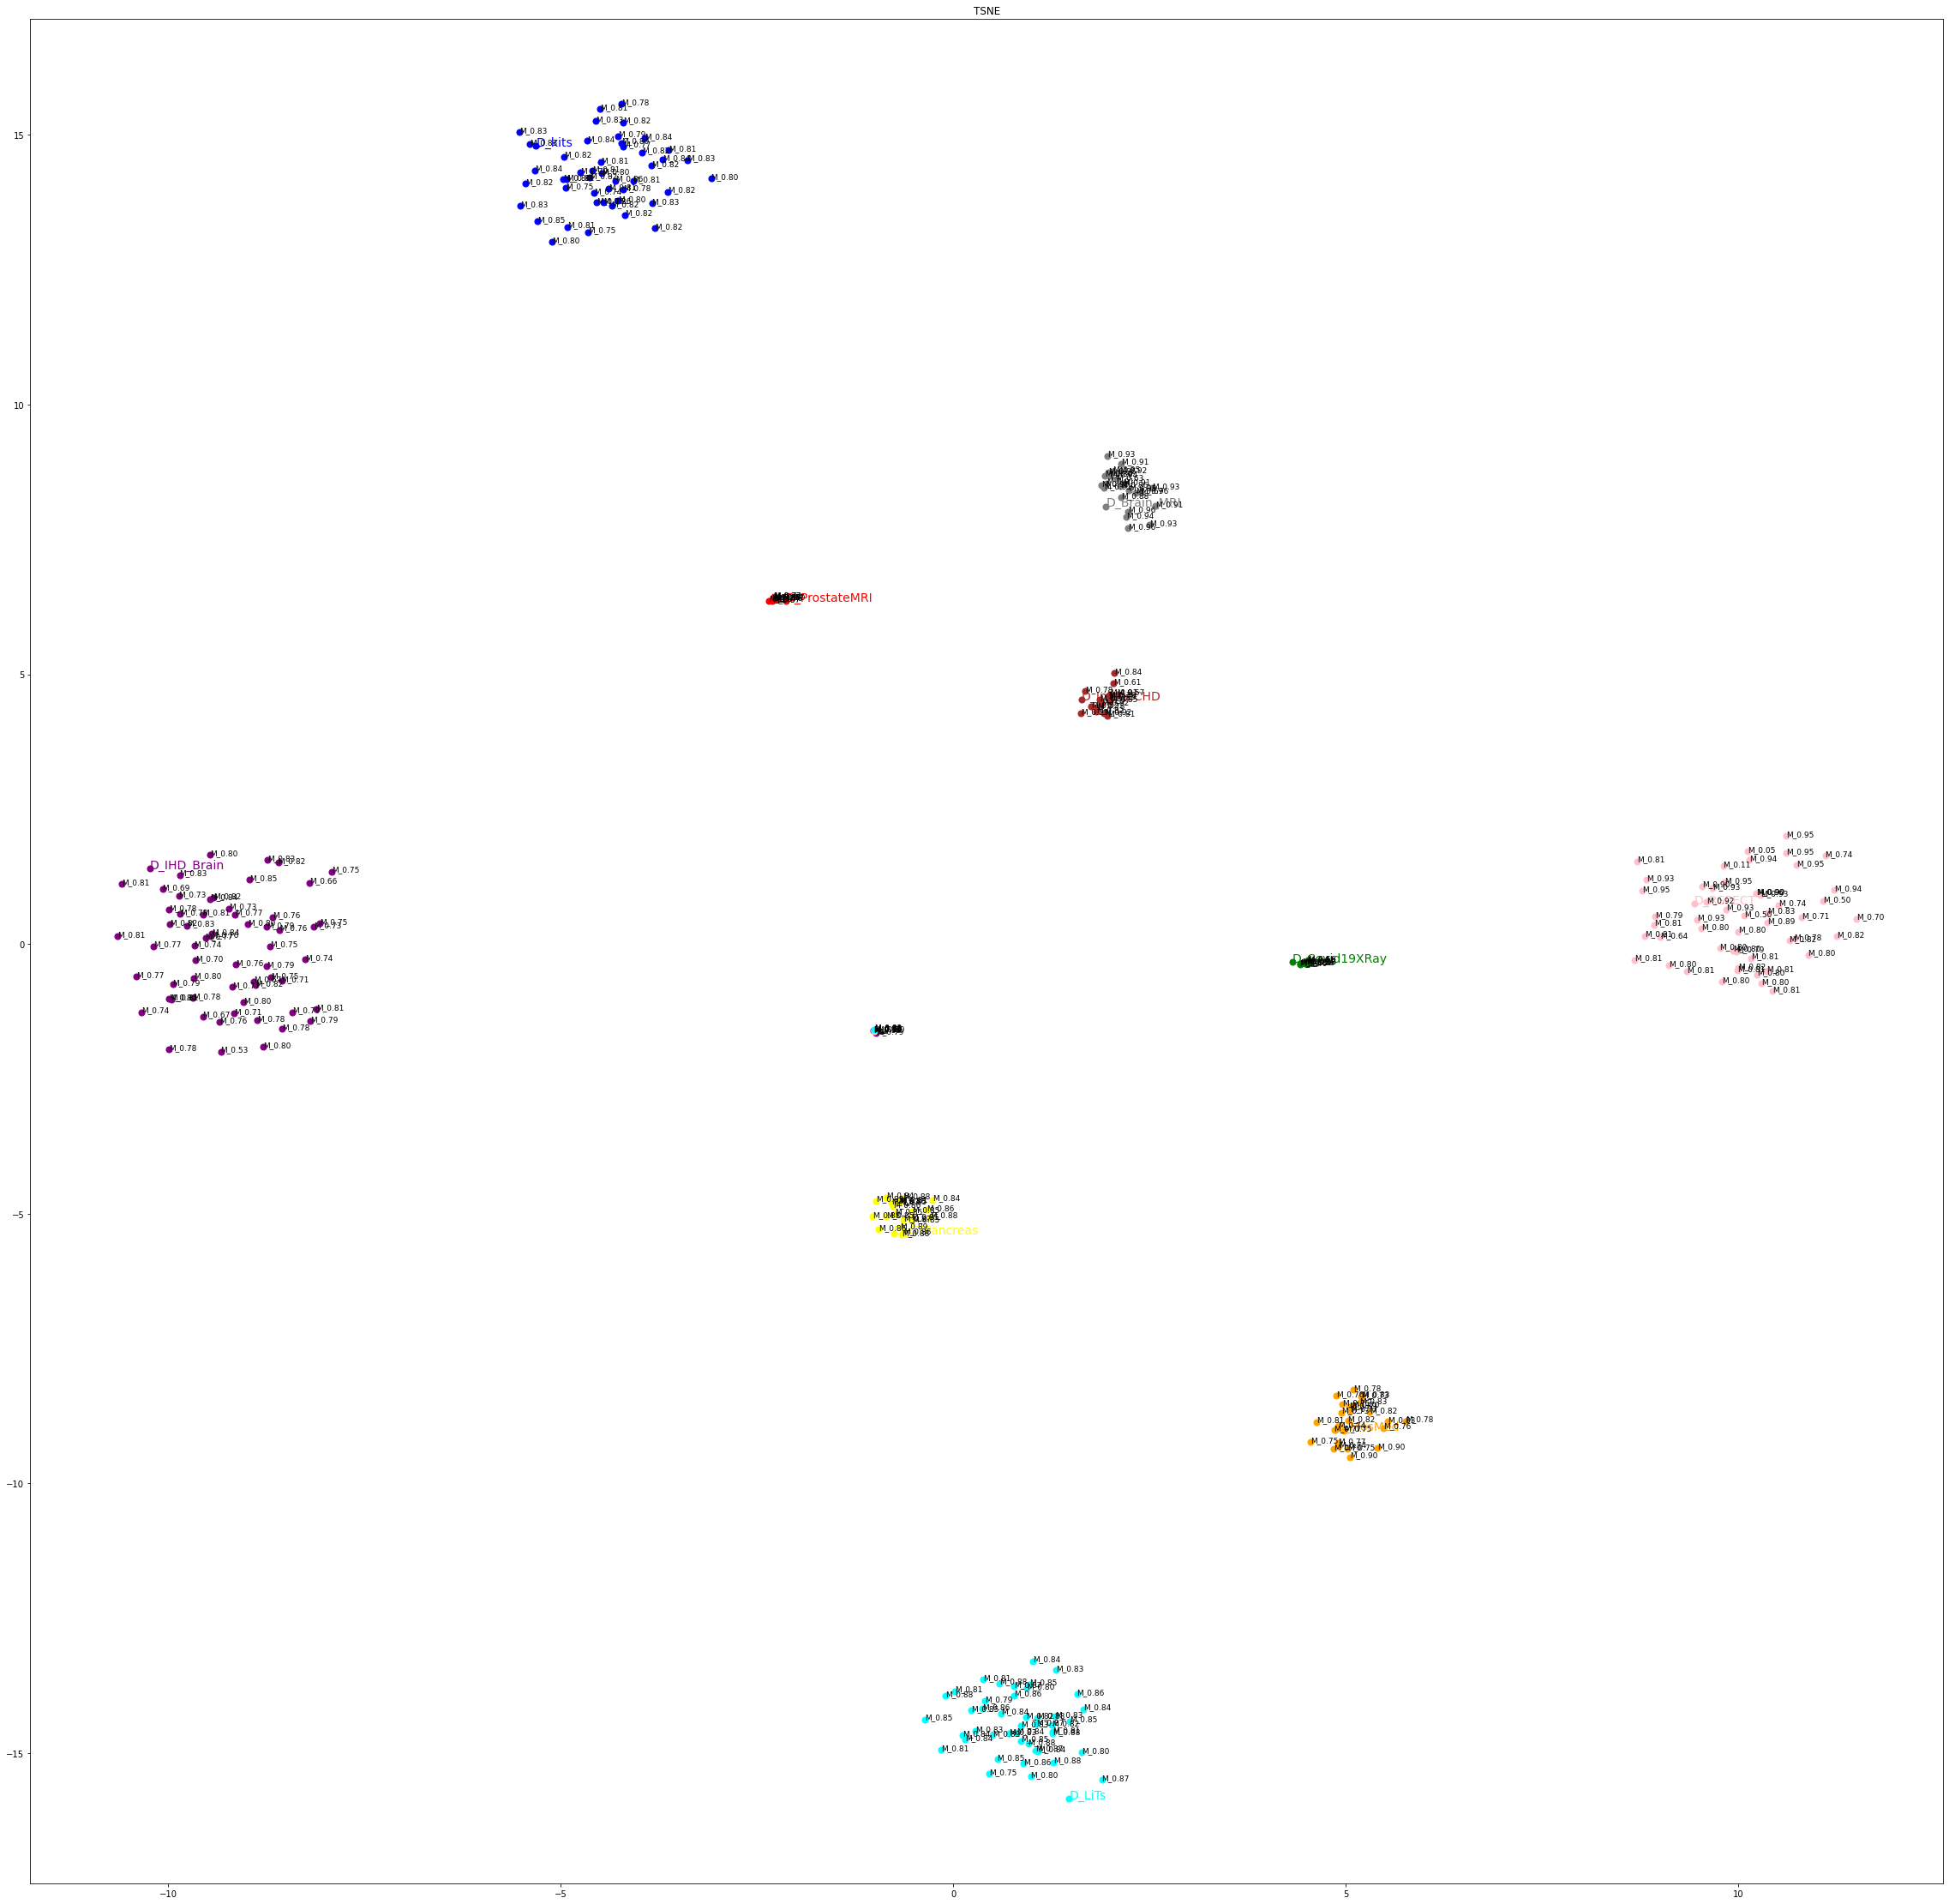

In [26]:
# TSNE Visualization
visualize_embeddings(data_emb_list, 'TSNE', 'tsne', return_emb=False)

# Isomap Visualization
visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=False)

In [28]:
# Use plotly to plot force directed graph representation of the distance matrix
import plotly.graph_objs as go

def plot_graph(distances, labels, title):
    x = [d[0] for d in distances]
    y = [d[1] for d in distances]
    z = [d[2] for d in distances]
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=12,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    )
    layout = go.Layout(
        title=title,
        width=800,
        height=800,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        scene=dict(
            xaxis=dict(
                title='PC1',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='PC2',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            ),
            zaxis=dict(
                title='PC3',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            )
        )
    )
    fig = go.Figure(data=[trace1], layout=layout)
    fig.show()



In [29]:
plot_graph(true_emb, true['color'], 'True Embeddings')